In [1]:
import tensorflow as tf 
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# check the files in the directory
print(os.listdir("drive/MyDrive/case_dataset-master/data/interpolated/annotations"))

# read the csv file
annotations_df = pd.read_csv("drive/MyDrive/case_dataset-master/data/interpolated/annotations/sub_1.csv")


['README_annotations.md', 'sub_1.csv', 'sub_2.csv', 'sub_3.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', 'sub_25.csv', 'sub_26.csv', 'sub_27.csv', 'sub_28.csv', 'sub_29.csv', 'sub_30.csv']


In [3]:
len(tf.config.list_physical_devices('GPU'))


1

In [4]:
def choose_subjects(Number):

    annotations_df = pd.read_csv("drive/MyDrive/case_dataset-master/data/interpolated/annotations/sub_1.csv")
    physiological_df = pd.read_csv("drive/MyDrive/case_dataset-master/data/interpolated/physiological/sub_1.csv")
    for i in range(2,Number+1) :
        chemin1='drive/MyDrive/case_dataset-master/data/interpolated/annotations/sub_{}.csv'.format(i)
        chemin2='drive/MyDrive/case_dataset-master/data/interpolated/physiological/sub_{}.csv'.format(i)
        annotations_df = pd.concat([annotations_df,pd.read_csv(chemin1)],axis=0)
        physiological_df = pd.concat([physiological_df,pd.read_csv(chemin2)],axis=0)
    return annotations_df,physiological_df

In [5]:
anno_df,physio_df=choose_subjects(1)


In [6]:
physio_df

,daqtime,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,video
0,0,0.846,38.172,11.749,27.610,29.495,7.288,8.684,6.550,10
1,1,0.836,38.249,11.737,27.601,29.488,7.288,8.725,6.468,10
2,2,0.843,38.058,11.757,27.600,29.488,7.329,8.726,6.589,10
3,3,0.836,38.075,11.730,27.572,29.481,7.207,8.644,6.468,10
4,4,0.852,38.210,11.745,27.591,29.484,7.247,8.765,6.507,10
...,...,...,...,...,...,...,...,...,...,...
2451579,2451579,1.020,36.902,7.262,27.010,26.876,5.932,5.727,5.194,12
2451580,2451580,1.014,36.990,7.259,27.020,26.876,5.892,5.727,5.112,12
2451581,2451581,1.020,36.463,7.239,27.048,26.879,5.933,5.809,5.274,12
2451582,2451582,1.023,36.602,7.227,27.030,26.883,5.974,5.769,5.316,12


In [7]:
def mapEmotions(df):
  # Define a dictionary to map video IDs to their corresponding emotions
  emotion_map = {1: 1, 2: 1, 3: 2, 4: 2, 
                5: 3, 6: 3, 7: 4, 8: 4,
                10: 3, 11: 5, 12: 6}
  df['emotion'] = df['video'].map(emotion_map)
  return df

In [8]:
anno_df=mapEmotions(anno_df)


In [9]:
def synchronize_and_resample(physio_df, anno_df):

  # Synchronize the dataframes
  physio_df['datetime'] = pd.to_datetime(physio_df['daqtime'], unit='ms')
  anno_df['datetime'] = pd.to_datetime(anno_df['jstime'], unit='ms')
  # Find the common timestamps between the two dataframes
  common_times = np.intersect1d(physio_df['daqtime'], anno_df['jstime'])

  # Filter the dataframes based on the common timestamps
  df_physio_synced = physio_df[physio_df['daqtime'].isin(common_times)]
  df_annotations_synced = anno_df[anno_df['jstime'].isin(common_times)]
  # Resample physiological signals to 50ms intervals
  df_physio_synced = df_physio_synced.set_index(['video', 'datetime'])
  df_physio_synced = df_physio_synced.reset_index()
  # Merge dataframes on video ID and synchronized timestamps
  merged_df = pd.merge(df_physio_synced, df_annotations_synced, on=['video', 'datetime'], how='inner')     
  # Check for missing or invalid data
  merged_df = merged_df.dropna()
  return merged_df

In [10]:
merged_df=synchronize_and_resample(physio_df, anno_df)
merged_df

,video,datetime,daqtime,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,jstime,valence,arousal,emotion
0,10,1970-01-01 00:00:00.000,0,0.846,38.172,11.749,27.610,29.495,7.288,8.684,6.550,0,5.0,5.0,3
1,10,1970-01-01 00:00:00.050,50,0.813,38.239,11.729,27.572,29.477,7.371,7.987,6.427,50,5.0,5.0,3
2,10,1970-01-01 00:00:00.100,100,0.790,38.045,11.737,27.591,29.477,7.536,7.493,6.344,100,5.0,5.0,3
3,10,1970-01-01 00:00:00.150,150,0.774,37.832,11.713,27.572,29.480,7.083,7.123,6.262,150,5.0,5.0,3
4,10,1970-01-01 00:00:00.200,200,0.931,37.309,11.717,27.600,29.474,7.452,7.041,6.342,200,5.0,5.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49025,12,1970-01-01 00:40:51.350,2451350,0.604,35.919,7.243,27.039,26.876,6.057,5.768,5.317,2451350,5.0,5.0,6
49026,12,1970-01-01 00:40:51.400,2451400,0.885,34.574,7.223,27.030,26.872,6.056,5.687,5.522,2451400,5.0,5.0,6
49027,12,1970-01-01 00:40:51.450,2451450,0.941,35.656,7.258,27.039,26.883,5.850,5.931,5.439,2451450,5.0,5.0,6
49028,12,1970-01-01 00:40:51.500,2451500,0.977,35.521,7.259,27.039,26.886,5.727,5.768,5.358,2451500,5.0,5.0,6


In [11]:
def preprocess_data(merged_df):

  features_df = merged_df.iloc[:,3:11]
  features_scaled=features_df.values
  #features_scaled = features_scaled.reshape(-1,1) #uncomment if using 1 feature
  min_max_scaler = sk.preprocessing.MinMaxScaler()
  features_scaled=min_max_scaler.fit_transform(features_scaled)

  # Extract the target variable
  target_df=merged_df.iloc[:,14]
  target=target_df.values
  return features_scaled, target


In [12]:
features_scaled, target=preprocess_data(merged_df)

In [13]:

def prepare_data(features, target, test_size=0.2, random_state=6):

    from sklearn.model_selection import train_test_split

    # Diviser les données en ensembles d'entraînement et de test
    x_Train, x_Test, y_Train, y_Test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Reformater les features en un tableau 3D
    x_Train = x_Train.reshape((x_Train.shape[0], x_Train.shape[1], 1))
    x_Test = x_Test.reshape((x_Test.shape[0], x_Test.shape[1], 1))

    return x_Train, x_Test, y_Train, y_Test



In [14]:

x_Train, x_Test, y_Train, y_Test = prepare_data(features_scaled, target)



In [15]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.85 :
            print("\nReached 89% accuracy, stopping training.")
            self.model.stop_training = True

In [16]:
from tensorflow import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

In [17]:


def train_model(x_train, y_train, epochs, batch_size, validation_split):
  L = []
  from tensorflow.keras import metrics
  from sklearn.metrics import precision_score, recall_score, f1_score
  from tensorflow.keras.metrics import Precision, Recall
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from keras.models import Sequential
  from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_Train.shape[1], 1)))
  model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(8, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics='accuracy')
  model.fit(x_Train, y_Train, epochs=100, batch_size=64)

  precision, recall = model.evaluate(x_Test, y_Test)

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
  history = model.fit(x_Train, y_Train, validation_split=validation_split, epochs=epochs, batch_size=batch_size)

  precision, recall = model.evaluate(x_Test, y_Test)
  L.append(model)
  L.append(history)
  return L

In [20]:
model, history=train_model(x_Train, y_Train, 100, 64, 0.2)

Epoch 1/100
491/491 [==============================] - 10s 8ms/step - loss: 1.0844 - accuracy: 0.5510 - val_loss: 0.7193 - val_accuracy: 0.7294
Epoch 2/100
491/491 [==============================] - 2s 5ms/step - loss: 0.6308 - accuracy: 0.7550 - val_loss: 0.5154 - val_accuracy: 0.7822
Epoch 3/100
491/491 [==============================] - 2s 4ms/step - loss: 0.4724 - accuracy: 0.8130 - val_loss: 0.3871 - val_accuracy: 0.8579
Epoch 4/100
491/491 [==============================] - 2s 5ms/step - loss: 0.3834 - accuracy: 0.8501 - val_loss: 0.3246 - val_accuracy: 0.8801
Epoch 5/100
491/491 [==============================] - 3s 6ms/step - loss: 0.3225 - accuracy: 0.8749 - val_loss: 0.2694 - val_accuracy: 0.8917
Epoch 6/100
491/491 [==============================] - 2s 4ms/step - loss: 0.2824 - accuracy: 0.8889 - val_loss: 0.2206 - val_accuracy: 0.9207
Epoch 7/100
491/491 [==============================] - 2s 4ms/step - loss: 0.2522 - accuracy: 0.9007 - val_loss: 0.2149 - val_accuracy: 0.910

In [21]:

def plot_training(history):

    import matplotlib.pyplot as plt

    # Plot training loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot training accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()




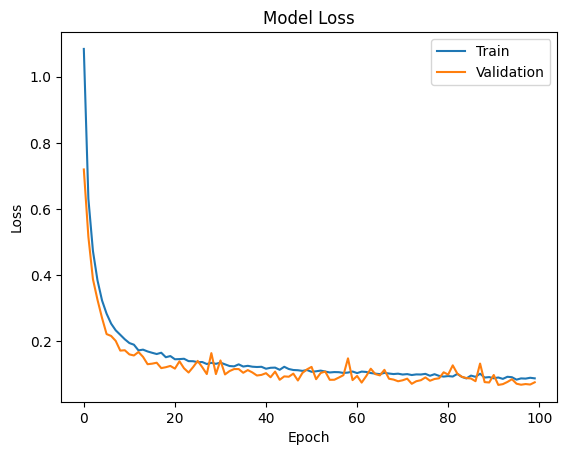

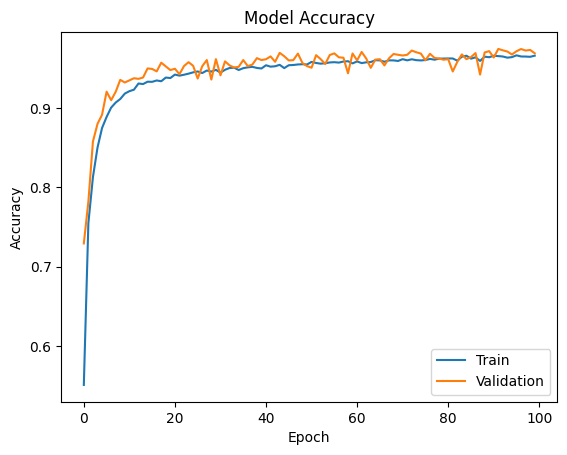

In [22]:
plot_training(history)

In [23]:

def evaluate_model(model, x_test, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    L=[]
    prediction = model.predict(x_test)
    y_pred = np.argmax(prediction, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    L.append(accuracy)
    L.append(precision)
    L.append(recall)
    L.append(f1)
    return L

In [ ]:
Evaluation=[]
Metriques=[]
for i in range(31):
    anno_df,physio_df=choose_subjects(i)
    anno_df=mapEmotions(anno_df)
    sync_df=synchronize_and_resample(physio_df,anno_df)
    features_scaled,target=preprocess_data(sync_df)
    x_Train, x_Test, y_Train, y_Test=prepare_data(features_scaled, target, test_size=0.2, random_state=6)
    Evaluation.append(train_model(x_Train, y_Train, epochs, batch_size, validation_split))
    Metriques.append(evaluate_model(Evaluation[i][0], x_Test, y_Test))


In [24]:
evaluate_model(model, x_Test, y_Test)

307/307 [==============================] - 1s 2ms/step
Accuracy: 0.9701203344890883
Precision: 0.9702530873849649
Recall: 0.9701203344890883
F1-score: 0.9701106497554304


(0.9701203344890883,
 0.9702530873849649,
 0.9701203344890883,
 0.9701106497554304)

In [25]:


def print_confusion_matrix(model, x_test, y_test):

    import numpy as np
    from sklearn.metrics import confusion_matrix
    # Get predictions for the test set
    y_pred = model.predict(x_test)

    # Convert predicted probabilities to predicted class labels
    y_pred = np.argmax(y_pred, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print confusion matrix
    print('Confusion matrix:')
    print(cm)


In [26]:
print_confusion_matrix(model, x_Test, y_Test)

307/307 [==============================] - 1s 2ms/step
Confusion matrix:
[[1361    0    0    0   12    0]
 [   0 1083    0    0   25    0]
 [   0    0 1559    0   34    0]
 [   0    0    0 1303   45    1]
 [  20   31   91   34 3705    0]
 [   0    0    0    0    0  502]]


In [27]:
y_pred = model.predict(x_Test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes


307/307 [==============================] - 1s 4ms/step


array([5, 2, 2, ..., 5, 4, 2])

In [28]:
vals, counts = np.unique(y_pred_classes, return_counts=True)

# afficher les résultats
for val, count in zip(vals, counts):
    print(f"{val} apparaît {count} fois dans le ndarray")

1 apparaît 1381 fois dans le ndarray
2 apparaît 1114 fois dans le ndarray
3 apparaît 1650 fois dans le ndarray
4 apparaît 1337 fois dans le ndarray
5 apparaît 3821 fois dans le ndarray
6 apparaît 503 fois dans le ndarray


In [32]:


def train_model(x_train, y_train, epochs, batch_size, validation_split):

  from tensorflow.keras import metrics
  from sklearn.metrics import precision_score, recall_score, f1_score
  from tensorflow.keras.metrics import Precision, Recall
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from keras.models import Sequential
  from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_Train.shape[1], 1)))
  model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(8, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics='accuracy')
  model.fit(x_Train, y_Train, epochs=100, batch_size=64)

  precision, recall = model.evaluate(x_Test, y_Test)

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
  history = model.fit(x_Train, y_Train, validation_split=validation_split, epochs=epochs, batch_size=batch_size)

  precision, recall = model.evaluate(x_Test, y_Test)

  return model, history

Epoch 1/100
613/613 [==============================] - 5s 5ms/step - loss: 0.7926 - accuracy: 0.6809
Epoch 2/100
613/613 [==============================] - 4s 6ms/step - loss: 0.3542 - accuracy: 0.8619
Epoch 3/100
613/613 [==============================] - 3s 4ms/step - loss: 0.2694 - accuracy: 0.8933
Epoch 4/100
613/613 [==============================] - 3s 4ms/step - loss: 0.2241 - accuracy: 0.9088
Epoch 5/100
613/613 [==============================] - 3s 4ms/step - loss: 0.2105 - accuracy: 0.9158
Epoch 6/100
613/613 [==============================] - 3s 5ms/step - loss: 0.2026 - accuracy: 0.9203
Epoch 7/100
613/613 [==============================] - 4s 6ms/step - loss: 0.1798 - accuracy: 0.9285
Epoch 8/100
613/613 [==============================] - 3s 4ms/step - loss: 0.1708 - accuracy: 0.9325
Epoch 9/100
613/613 [==============================] - 3s 5ms/step - loss: 0.1761 - accuracy: 0.9299
Epoch 10/100
613/613 [==============================] - 3s 5ms/step - loss: 0.1628 - accura

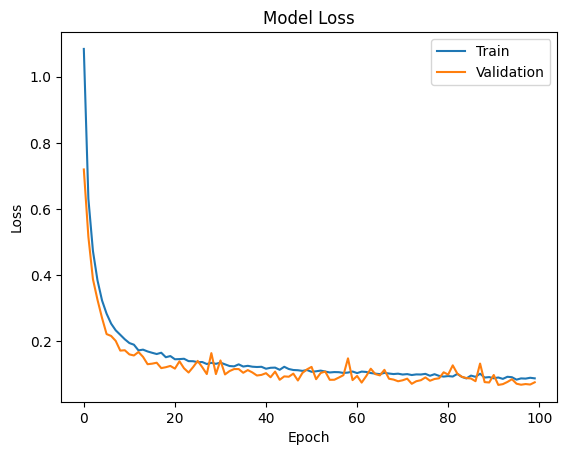

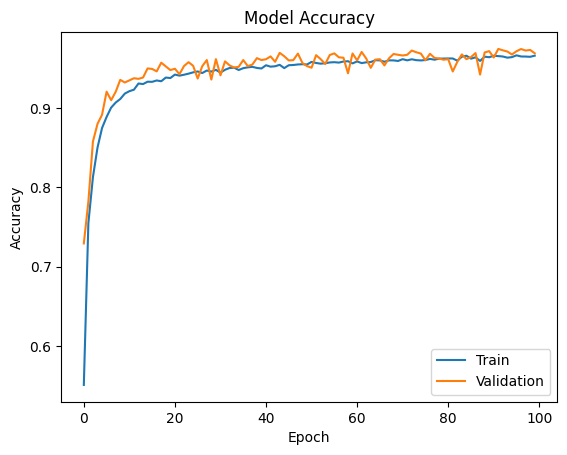

In [33]:
plot_training(history)

In [35]:
evaluate_model(model, x_Test, y_Test)


307/307 [==============================] - 2s 5ms/step
Accuracy: 0.9818478482561697
Precision: 0.981935851019809
Recall: 0.9818478482561697
F1-score: 0.9818641034739268


(0.9818478482561697, 0.981935851019809, 0.9818478482561697, 0.9818641034739268)

In [36]:
print_confusion_matrix(model, x_Test, y_Test)

307/307 [==============================] - 1s 3ms/step
Confusion matrix:
[[1356    0    0    0   17    0]
 [   0 1086    0    0   22    0]
 [   0    0 1550    0   43    0]
 [   0    0    0 1324   25    0]
 [  10   15   13   30 3813    0]
 [   0    0    0    3    0  499]]
